# Random trees

## Introduction

This notebook explores different ways to define and train random trees.  We will start by covering the usual scikit learn approach, and then we will explore how suitable MxNet it is for writing this kind of software. We will start with a description of the algorithm followed by a discussion about its parallelization and distribution properties. Finally we will produce an implementatino using:

* [scikit-learn](http://scikit-learn.org/stable/modules/tree.html)
* MxNet
* XGBoost
* GNU Shogun (http://www.shogun-toolbox.org/)
* [OpenCV](http://docs.opencv.org/3.1.0/dc/dd6/ml_intro.html#ml_intro_trees). There is currently no support for decision trees or random forest in cv2 (opencv python library)

### Build OpenCV python

I had to rename the system python libraries, so that CMake would see the anaconda ones. After that, the following command got the job done

```bash
cmake -D CMAKE_BUILD_TYPE=Release -D CMAKE_INSTALL_PREFIX=/usr/local -D PYTHON_INCLUDE_DIR="/home/ec2-user/anaconda2/include/python2.7" -D PYTHON_PACKAGES_PATH="/home/ec2-user/anaconda2/lib/python2.7/site-packages" -D PYTHON2_EXECUTABLE="/home/ec2-user/anaconda2/bin/python2.7" -D PYTHON_LIBRARY="/home/ec2-user/anaconda2/lib/libpython2.7.so" -DOPENCV_EXTRA_MODULES_PATH="../../opencv_contrib/modules/" ..

make -j2
```

### Implementation articles (naive)

* http://gabrielelanaro.github.io/blog/2016/03/03/decision-trees.html
* http://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/

## Radom forest algorithm

### Decision tress

#### CART

http://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/

#### ID3

* [wikipedia](https://en.wikipedia.org/wiki/ID3_algorithm)

#### C4.5

* [wikipedia](https://en.wikipedia.org/wiki/C4.5_algorithm)

#### Incremental algorithms

All the algorithms mentioned above process the entiner dataset in one pass to produce the resulting decision tree. However, for large datasets or datasets of high dimensionality it maybe benefitial to use a minibatch approach. A few altorithms have been devised for the incremental training of decision trees (see [wikipedia](https://en.wikipedia.org/wiki/Incremental_decision_tree))

### Bagging


## Parallel execution of random trees

When we think about exploiting parallism, it seems that random forest are  good candidates for per-core parallelization. In theory each of the trees can be trained by a different core, and at the end the model can be put together. This model should be simple to implement for a single machine.

## Scikit learn

[Random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) support in scki-learn is nice and easy, as are most of its features. Sklearn offers 2 types of random forest:

* RandomForestClassifier
* RandomForestRegressor

In [1]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd

# Load iris dataset
iris_bunch = datasets.load_iris()
X = pd.DataFrame(iris_bunch.data)
y = pd.DataFrame(iris_bunch.target)

# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

Now that we have loaded our data, we will create a random forest classifier, and will time its training time for different parameters. We are particularly interested in the number of  trees.

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:257: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


1 loop, best of 3: 462 ms per loop


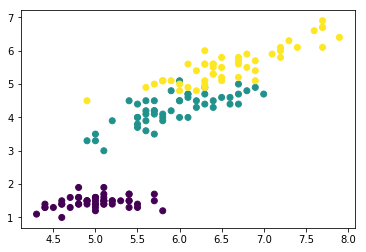

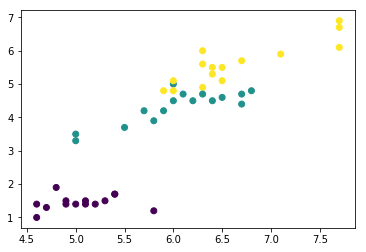

In [2]:
forest = ensemble.RandomForestClassifier(n_estimators=200)
%timeit forest.fit(X_train,y_train)

# Of course we would like to visualize the results. WARNING: We are not using any kind of Split here
import matplotlib.pyplot as plt

# Training dataset
plt.scatter(X[0], X[2], c=y)
plt.show()

# Test dataset
pred = forest.predict(X_test)
plt.scatter(X_test[0], X_test[2], c=pred)
plt.show()

In [3]:
# K-fold validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(forest, X, y.values.reshape(len(X)), cv=10)
scores

array([ 1.        ,  0.93333333,  1.        ,  0.93333333,  0.93333333,
        0.93333333,  0.93333333,  1.        ,  1.        ,  1.        ])

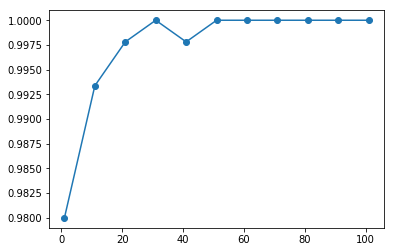

In [4]:
# Let's do validation curves
from sklearn.model_selection import validation_curve

param_range = range(1, 111, 10)
train_scores, valid_scores = validation_curve(ensemble.RandomForestClassifier(), 
                                              X, y.values.reshape(len(X)), 
                                              "n_estimators", param_range, cv=4)
                                              
plt.plot(param_range, train_scores.mean(axis=1), marker='o')
plt.show()